# Introduction to Julia for Data Science
## Advanced predictive models using Machine Learning (13:00-15:00)
Day 2 (Wednesday, Jan 18, 2023)

## 1. Machine Learning Engineering

![](img/ML_Workflow.png)
<div style="text-align: right">Source: Burkov Andriy, ML Engineering, 2020, CC BY-SA 4.0</div> 

Lifecycle of Machine Learning project is a complex process involving multiple areas of expertise and set of skills. To succeed with an enterprise-level ML project, we'll need:
* project managers, product owners and business analysts with good understanding of business problem and ability to define the goal and manage the execution of the initiative,
* data engineers, data analysts and data scientists with in-depth knowledge about the data, technical skills and statistical (modelling) expertise,
* DevOps engineers, software engineers, application developers taking care of model deployment in secure, robust and performant manner, often with embedment into a bigger application.

Increasing penetration of ML models in the business and advancements in the deployment areas created a new area of **Machine Learning engineering** and corresponding position of **Machine Learning engineer**. Activities related to post-evaluation steps are also often reffered to as **MLOps (Machine Learning Operations)**, similarly to operations term used for ongoing maintanance and monitoring of software applications.

Due to the complexity of the process, multiple frameworks, tools and packages are created to handle multiple steps in the Machine Learning pipeline:
* data preprocessing and cleaning,
* feature engineering,
* model evaluation and reporting the model's quality,
* training and hyperparameter tuning of multiple models,
* model deployment and serving.

In Julia one of prominent package for standardizing ML process is [`MLJ`](https://github.com/alan-turing-institute/MLJ.jl/tree/master). We'll use the framework to streamline data preprocessing, model building and evaluation.

## 2. Loading the dataset

Let's load the [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) data and predict if the client will subscribe to a term deposit (variable `y`). 

The dataset contains attributes related to:
* characteristics of the bank's client,
* statistics from the ongoing and previous marketing campaigns,
* social and economic indicators.

Note that `Logging` package is used to turn off the messages on the INFO and DEBUG levels to keep the output in the notebook cleaner - to learn more about logging in Julia check the [standard library documentation](https://docs.julialang.org/en/v1/stdlib/Logging/).

In [10]:
using MLJ
using CSV, DataFrames
using Random, Logging
using Plots
Logging.disable_logging(Logging.Info)

LogLevel(1)

Let's load the Bank Marketing data and inspect the data.

In [11]:
df = CSV.read("bank-additional-full.csv", DataFrame, delim=";")

Row,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,Int64,String15,String15,String31,String7,String7,String7,String15,String3,String3,Int64,Int64,Int64,Int64,String15,Float64,Float64,Float64,Float64,Float64,String3
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


`MLJ` use the notion of the **scientific types** beside the data types. Scientific types specify how the features should be interpreted by the ML models and the users - the basic types are:
* `Continuous`, 
* `Multiclass{N}`, 
* `OrderedFactor{N}`, 
* `Count`,
* `Textual`.

More information about the scientific types can be found in the [MLJ documentation](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Data-containers-and-scientific-types). The `schema` function will produce a data type and scientific type for each column in the dataset.

In [12]:
schema(df)

┌────────────────┬────────────┬──────────┐
│ names          │ scitypes   │ types    │
├────────────────┼────────────┼──────────┤
│ age            │ Count      │ Int64    │
│ job            │ Textual    │ String15 │
│ marital        │ Textual    │ String15 │
│ education      │ Textual    │ String31 │
│ default        │ Textual    │ String7  │
│ housing        │ Textual    │ String7  │
│ loan           │ Textual    │ String7  │
│ contact        │ Textual    │ String15 │
│ month          │ Textual    │ String3  │
│ day_of_week    │ Textual    │ String3  │
│ duration       │ Count      │ Int64    │
│ campaign       │ Count      │ Int64    │
│ pdays          │ Count      │ Int64    │
│ previous       │ Count      │ Int64    │
│ poutcome       │ Textual    │ String15 │
│ emp.var.rate   │ Continuous │ Float64  │
│ cons.price.idx │ Continuous │ Float64  │
│ cons.conf.idx  │ Continuous │ Float64  │
│ euribor3m      │ Continuous │ Float64  │
│ nr.employed    │ Continuous │ Float64  │
│ y        

The default mapping between the data and scientific types didn't produce the desired outcome. Let's use `coerce` function to change all `Textual` types to `Multiclass` and `age` feature to the `Continuous` type. The binary target variable `y` is also coerced to `OrderedFactor` which will indicate `yes` value to be intepreted as positive class during classification. Note that after the conversion data types changed as well.

In [13]:
df = coerce(df, :age => Continuous, Textual => Multiclass);
df = coerce(df, :y => OrderedFactor)
schema(df)

┌────────────────┬──────────────────┬────────────────────────────────────┐
│ names          │ scitypes         │ types                              │
├────────────────┼──────────────────┼────────────────────────────────────┤
│ age            │ Continuous       │ Float64                            │
│ job            │ Multiclass{12}   │ CategoricalValue{String15, UInt32} │
│ marital        │ Multiclass{4}    │ CategoricalValue{String15, UInt32} │
│ education      │ Multiclass{8}    │ CategoricalValue{String31, UInt32} │
│ default        │ Multiclass{3}    │ CategoricalValue{String7, UInt32}  │
│ housing        │ Multiclass{3}    │ CategoricalValue{String7, UInt32}  │
│ loan           │ Multiclass{3}    │ CategoricalValue{String7, UInt32}  │
│ contact        │ Multiclass{2}    │ CategoricalValue{String15, UInt32} │
│ month          │ Multiclass{10}   │ CategoricalValue{String3, UInt32}  │
│ day_of_week    │ Multiclass{5}    │ CategoricalValue{String3, UInt32}  │
│ duration       │ Count 

## 3. Data preprocsessing

After modifying the schema, let's proceed with further preprocessing. `unpack` function splits the dataset into independent variables (`X`) and target variable (`y`). Features can also be removed in the same step - let's remove the `duration` variable as it's highly related to the target and recommended for removal by the dataset owner (for details check the `bank-additional-names.txt`).

In [14]:
combine(groupby(df, :y), :duration .=> [minimum median mean])

Row,y,duration_minimum,duration_median,duration_mean
,Cat…,Int64,Float64,Float64
1,no,0,163.5,220.845
2,yes,37,449.0,553.191


Statistics calculated above confirm close relation between target variable and duration of the call - mean `duration` is significantly higher, when customer subscribed to the term deposit. Let's proceed with splitting the dataset and removal of the `duration` variable.

In [15]:
y, X = unpack(df, ==(:y), !=(:duration));

After the split, `y` is a `CategoricalArray` with two levels: "no" and "yes".

In [16]:
y

41188-element CategoricalArrays.CategoricalArray{String3,1,UInt32}:
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 ⋮
 String3("no")
 String3("no")
 String3("yes")
 String3("no")
 String3("no")
 String3("yes")
 String3("no")
 String3("yes")
 String3("no")
 String3("no")
 String3("yes")
 String3("no")

`X` remains a `DataFrame` with `duration` and `y` columns gone.

In [17]:
X

Row,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
,Float64,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Int64,Int64,Int64,Cat…,Float64,Float64,Float64,Float64,Float64
1,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,37.0,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
5,56.0,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
6,45.0,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
7,59.0,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
8,41.0,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
9,24.0,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In most cases data needs to be preprocessed to be properly used for ML models training. `MLJ` has multiple transformers to help with common data preparation tasks, in particular:
* standardizing the numeric features,
* one-hot encoding the nominal features,
* transforming skewed numeric features,
* imputing the missing values.

Let's use `Standardizer` and `OneHotEncoder` transformers on the Bank Marketing data - both [standardization](https://en.wikipedia.org/wiki/Standard_score) and [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) are common preprocessing steps. By default `Standardizer` standardize only features with `Continuous` scientific type. Similarly, `OneHotEncoder` transforms only `Multiclass` and `OrderedFactor` types. Multiple preparation steps can be combined in **pipelines** by using the `Pipeline` constructor or `|>` symbol - pipelines make repetitive tasks simpler and easier to execute.

`MLJ` expose a common interface for managing and manipulating transformers, models and other objects. To run the preprocessing pipeline we'll utilize:
* `machine` function which binds an algorithm (model, transformer, pipelines, etc.) to the data,
* `fit!` function for training the algorithm,
* `transform` function to use trained pipepline to get the standardized and one-hot encoded dataset.

The cell below will show a transformed `DataFrame` - look how it differs from the input.

In [18]:
preproc_pipe = Standardizer() |> OneHotEncoder()
preproc_wrapped = machine(preproc_pipe, X)
X_prepared = MLJ.transform(fit!(preproc_wrapped), X)

Row,age,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,job__self-employed,job__services,job__student,job__technician,job__unemployed,job__unknown,marital__divorced,marital__married,marital__single,marital__unknown,education__basic.4y,education__basic.6y,education__basic.9y,education__high.school,education__illiterate,education__professional.course,education__university.degree,education__unknown,default__no,default__unknown,default__yes,housing__no,housing__unknown,housing__yes,loan__no,loan__unknown,loan__yes,contact__cellular,contact__telephone,month__apr,month__aug,month__dec,month__jul,month__jun,month__mar,month__may,month__nov,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,campaign,pdays,previous,poutcome__failure,poutcome__nonexistent,poutcome__success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.53302,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
2,1.62897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
3,-0.290182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
4,-0.00230878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
5,1.53302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
6,0.47748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
7,1.82089,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
8,0.093649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
9,-1.53763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676


Using another element from the common interface - `fitted_params` function - we can inspect the parameters learned by the `Standardizer` while running `fit!`.

In [19]:
fitted_params(preproc_wrapped).standardizer

(features_fit = [:euribor3m, Symbol("cons.price.idx"), :age, Symbol("nr.employed"), Symbol("cons.conf.idx"), Symbol("emp.var.rate")],
 means = (3.6212908128581147, 93.57566436826264, 40.02406040594348, 5167.035910944927, -40.502600271923846, 0.08188550063125229),
 stds = (1.7344474048512668, 0.5788400489541262, 10.421249980934048, 72.25152766826103, 4.628197856174543, 1.5709597405170248),)

## 4. MLJ as repository of models

`MLJ` framework also works as a repository and wrapper of ML models built in various Julia packages. Using `models` function, let's check which models will be suited to the posed classification task considering types of predictors and target variable. Additionally, let's find only models fully implemented in Julia.

Before a particular model will be used in the `MLJ` workflow, it must be available in the environment. `load_path` function returns a package need for each model. 

For further work let's use:
* `RandomForestClassifier` from `DecisionTree` package,
* `EvoTreeClassifier` from `EvoTrees` package,
* `LinearPerceptron` from `BetaML` package.

Required packages are listed below (but you don't need to worry about that - packages are already loaded from the `Project.toml`).

In [20]:
for (model, pkg) in [("RandomForestClassifier", "DecisionTree"),
                     ("EvoTreeClassifier", "EvoTrees"),
                     ("LinearPerceptron", "BetaML")]
println(load_path(model, pkg=pkg))
end

MLJDecisionTreeInterface.RandomForestClassifier
EvoTrees.EvoTreeClassifier
BetaML.Perceptron.LinearPerceptron


We can load the models with the `@load` macro. If the model name appears in more than one package, the package name must be explicitly stated.

In [21]:
Forest = @load RandomForestClassifier pkg="DecisionTree"
Evo = @load EvoTreeClassifier
Perc = @load LinearPerceptron

import MLJDecisionTreeInterface ✔
import EvoTrees ✔
import BetaML ✔


BetaML.Perceptron.LinearPerceptron

## 5. Training and evaluating the models

We are ready to train the loaded models - let's streamline the training and evaluation process with `MLJ`. The models with the default hyperparameter values are wrapped in the `evaluate` function which will do the following:
* split the provided data according to the resampling strategy - in the case below the `Holdout` specifies the data split into train/test subsets with 80/20 ratio and random seed equal to 42,
* fit the model on the training data and evaluate it on the test data calculating each measure specified in the `measure` parameter,
* return the evaluation report with relevant information.

In [22]:
measures = [accuracy, auc, f1score]
split = Holdout(fraction_train=0.8, rng=42)
rng_mt = MersenneTwister(42)
for m in [Forest, Evo, Perc]
    eval_report = evaluate(m(rng=rng_mt), X_prepared, y, resampling=split, measure=measures)
    println(m)
    println.(eval_report.measure, ": ", round.(eval_report.measurement, digits=3))
    println()
end

MLJDecisionTreeInterface.RandomForestClassifier
Accuracy(): 0.892
AreaUnderCurve(): 0.753
FScore(β = 1.0, …): 0.352

EvoTrees.EvoTreeClassifier
Accuracy(): 0.894
AreaUnderCurve(): 0.735
FScore(β = 1.0, …): 0.315



Training Perceptron... 100%|█████████████████████████████| Time: 0:00:12


BetaML.Perceptron.LinearPerceptron
Accuracy(): 0.466
AreaUnderCurve(): 0.625
FScore(β = 1.0, …): 0.254



Three ML models with the default hyperparameters values were built and evaluated. Out of the trained models `RandomForestClassifier` achieved the best AUC and F1-score. Let's tune the hyperparameters of the Random Forest  based on the AUC metric. 

The list of available hyperparemeters and their default values is displayed when the instance of the Random Forest is called. 

In [23]:
forest = Forest(rng=rng_mt)

RandomForestClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 10, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = MersenneTwister(42, (0, 46171206, 46170204, 441, 38874, 939)))

To learn more about each hyperparameter review documentation for `RandomForestClassifier` by calling `?Forest()`. 

In [24]:
?Forest()

```
RandomForestClassifier
```

A model type for constructing a CART random forest classifier, based on [DecisionTree.jl](https://github.com/bensadeghi/DecisionTree.jl), and implementing the MLJ model interface.

From MLJ, the type can be imported using

```
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree
```

Do `model = RandomForestClassifier()` to construct an instance with default hyper-parameters. Provide keyword arguments to override hyper-parameter defaults, as in `RandomForestClassifier(max_depth=...)`.

`RandomForestClassifier` implements the standard [Random Forest algorithm](https://en.wikipedia.org/wiki/Random_forest), originally published in Breiman, L. (2001): "Random Forests.", *Machine Learning*, vol. 45, pp. 5–32.

# Training data

In MLJ or MLJBase, bind an instance `model` to data with

```
mach = machine(model, X, y)
```

where

  * `X`: any table of input features (eg, a `DataFrame`) whose columns each have one of the following element scitypes: `Continuous`, `Count`, or `<:OrderedFactor`; check column scitypes with `schema(X)`
  * `y`: the target, which can be any `AbstractVector` whose element scitype is `<:OrderedFactor` or `<:Multiclass`; check the scitype with `scitype(y)`

Train the machine with `fit!(mach, rows=...)`.

# Hyper-parameters

  * `max_depth=-1`:          max depth of the decision tree (-1=any)
  * `min_samples_leaf=1`:    min number of samples each leaf needs to have
  * `min_samples_split=2`:   min number of samples needed for a split
  * `min_purity_increase=0`: min purity needed for a split
  * `n_subfeatures=-1`: number of features to select at random (0 for all, -1 for square root of number of features)
  * `n_trees=10`:            number of trees to train
  * `sampling_fraction=0.7`  fraction of samples to train each tree on
  * `feature_importance`: method to use for computing feature importances. One of `(:impurity, :split)`
  * `rng=Random.GLOBAL_RNG`: random number generator or seed

# Operations

  * `predict(mach, Xnew)`: return predictions of the target given features `Xnew` having the same scitype as `X` above. Predictions are probabilistic, but uncalibrated.
  * `predict_mode(mach, Xnew)`: instead return the mode of each prediction above.

# Fitted parameters

The fields of `fitted_params(mach)` are:

  * `forest`: the `Ensemble` object returned by the core DecisionTree.jl algorithm

# Report

  * `features`: the names of the features encountered in training

# Examples

```
using MLJ
Forest = @load RandomForestClassifier pkg=DecisionTree
forest = Forest(min_samples_split=6, n_subfeatures=3)

X, y = @load_iris
mach = machine(forest, X, y) |> fit!

Xnew = (sepal_length = [6.4, 7.2, 7.4],
        sepal_width = [2.8, 3.0, 2.8],
        petal_length = [5.6, 5.8, 6.1],
        petal_width = [2.1, 1.6, 1.9],)
yhat = predict(mach, Xnew) # probabilistic predictions
predict_mode(mach, Xnew)   # point predictions
pdf.(yhat, "virginica")    # probabilities for the "verginica" class

fitted_params(mach).forest # raw `Ensemble` object from DecisionTrees.jl

feature_importances(mach)  # `:impurity` feature importances
forest.feature_importance = :split
feature_importance(mach)   # `:split` feature importances

```

See also [DecisionTree.jl](https://github.com/bensadeghi/DecisionTree.jl) and the unwrapped model type [`MLJDecisionTreeInterface.DecisionTree.RandomForestClassifier`](@ref).


## 6. Cross-validation and hyperparameter tuning

Tuning all hyperparameters of `RandomForestClassifier` would be computionally demanding. To finish within a reasonable time, we'll tune two arbitrary picked hyperparameters: `max_depth` and `n_trees`. `max_depth` limits the growth of each tree in the ensemble - deep trees may be overfitted, while shallow trees may be biased. `n_trees` determines number of trees in the ensemble - the predictive power of the forest should initially increase with the number of trees and then saturate.

Tuning in `MLJ` can be performed easily with `TunedModel` interface. The tuning specification includes:
* `model` - the model to be tuned, in our case an instance of `RandomForestClassifier`,
* `resampling` - mechanism for splitting the data into training and validation subsets, e.g. cross-validation (below 4-fold cross-validation specified in `CV` resampling strategy),
* `tuning` - tuning strategy for searching the hyperparameters space, in the example below `Grid(resolution=6)` constructs grid search with cartesian product of six evenly spaced values for each tuned hyperparameter (36 models for two tuned hyperparameters),
* `range` - specification of tuned hyperparameters including hyperparameter names and their extreme values,
* `measure` - metric used for models evaluation - as specfied above, AUC is used.

Please note the tuning is computationally intensive excercise and may take few minutes to complete. The progress bar will indicate how many models are already evaluated.

<img src="img/cross_val.png" alt="cross_val" width="60%"/>
<div style="text-align: right">Source: <a href="https://scikit-learn.org/stable/modules/cross_validation.html">Scikit-Learn documentation</a>, BSD-3 License</div> 

In [25]:
hyperparam_range = [range(forest, :n_trees, lower=10, upper=80),
                    range(forest, :max_depth, lower=2, upper=30)]
self_tuning_forest = TunedModel(
    model=forest,
    resampling=CV(nfolds=4, rng=rng_mt),
    tuning=Grid(resolution=6),
    range=hyperparam_range,
    measure=auc)
mach = machine(self_tuning_forest, X_prepared, y)
fit!(mach, verbosity=1)

Evaluating over 36 metamodels: 100%[=========================] Time: 0:02:57


trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = RandomForestClassifier(max_depth = -1, …), …)
  args: 
    1:	Source @334 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}
    2:	Source @830 ⏎ AbstractVector{OrderedFactor{2}}


Inspect the results of the tuning on the plots with `plot` function. As expected, the AUC was raising with increasing number of trees and stabilised around 60 trees. Optimal value of `max_depth` is close to 25 - deeper models are overfitted, while smaller underfitted.

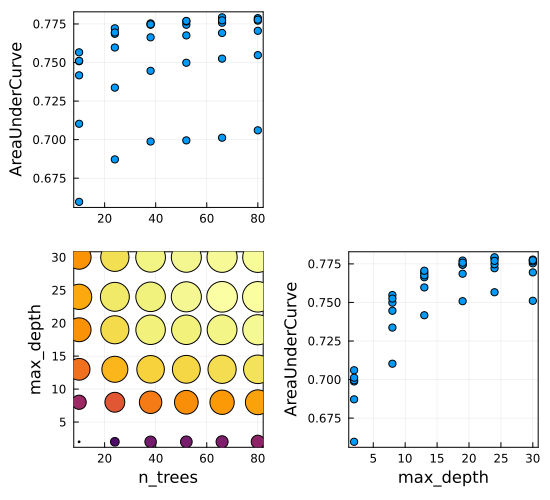

In [26]:
plot(mach)

Let's see the specification of the best model - `max_depth` is set to 24 and `n_trees` to 66, while other hyperparameters retained default values.

In [27]:
best_model = fitted_params(mach).best_model

RandomForestClassifier(
  max_depth = 24, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 66, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = MersenneTwister(42, (0, 46171206, 46170204, 441, 38874, 944)))

Using initial `evaluate` call we can easily compare tuned model performance to the default forest.

In [28]:
evaluate(best_model, X_prepared, y, resampling=split, measure=measures)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌──────────────────┬──────────────┬─────────────┬──────────┐
│ measure          │ operation    │ measurement │ per_fold │
├──────────────────┼──────────────┼─────────────┼──────────┤
│ Accuracy()       │ predict_mode │ 0.9         │ [0.9]    │
│ AreaUnderCurve() │ predict      │ 0.795       │ [0.795]  │
│ FScore(          │ predict_mode │ 0.396       │ [0.396]  │
│   β = 1.0,       │              │             │          │
│   rev = nothing) │              │             │          │
└──────────────────┴──────────────┴─────────────┴──────────┘


In the usual ML workflow, all candidate models (in our example those were: `RandomForestClassifier`, `EvoTreeClassifier`, `LinearPerceptron`) would be tuned and the best model from each class would be assessed on the holdout set to pick the best overall model. We didn't follow the approach as it would be time consuming and the additional tuning steps are analogous to the one performed.

In [29]:
predict(mach, X_prepared[1:10,:])

10-element CategoricalDistributions.UnivariateFiniteVector{OrderedFactor{2}, String3, UInt32, Float64}:
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>0.985, yes=>0.0152)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>0.955, yes=>0.0455)
 UnivariateFinite{OrderedFactor{2}}(no=>0.97, yes=>0.0303)

For the model deployment `MLJ` models can be saved to disk with `save` function - for details check the [Saving machines section in the documentation](https://alan-turing-institute.github.io/MLJ.jl/dev/machines/#Saving-machines).

In [47]:
MLJ.save("forest.mlj", mach)

In [48]:
mach_predict_only = machine("forest.mlj")

trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = RandomForestClassifier(max_depth = -1, …), …)
  args: 


In [50]:
predict(mach_predict_only, X_prepared[1:10,:])

10-element CategoricalDistributions.UnivariateFiniteVector{OrderedFactor{2}, String3, UInt32, Float64}:
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>0.985, yes=>0.0152)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>1.0, yes=>0.0)
 UnivariateFinite{OrderedFactor{2}}(no=>0.955, yes=>0.0455)
 UnivariateFinite{OrderedFactor{2}}(no=>0.97, yes=>0.0303)

*Preparation of this workshop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.*

![SGH & NAWA](img/logo.png)